In [327]:
import ot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import scanpy as sc

In [324]:
prot_data_path = "/home/wuxinchao/data/st_cite_data/B01825A4_protein_filter.csv"
rna_data_path = "/home/wuxinchao/data/st_cite_data/B01825A4_rna_raw.csv"

In [325]:
prot_data = pd.read_csv(prot_data_path)
rna_data = pd.read_csv(rna_data_path)

In [326]:
# prot_data
# rna_data
gene_map = {
    "CD11c": "Itgax",
    "CD27" : "Cd27",
    "CD8a" : "Cd8a",
    "CD68" : "Cd68",
    "2" : "Thy1",
    "CD3" : "Cd3g",
    "CD44" : "Cd44",
    "CD5" : "Cd5",
    "CD4" : "Cd4",
    "CD29" : "Itgb1"
}
# gene_map["CD27"]

In [8]:
a = [.5, .5]
b = [.4, .6]
M = [[0, 1], [1, 0]]
ot.sinkhorn2(a, b, M, 1)

0.2805354607075431

In [7]:
ot.emd2(a, b, M)

0.09999999999999998

The Sinkhorn-Knopp algorithm is implemented in `ot.sinkhorn` and `ot.sinkhorn2` that return respectively the OT matrix and the value of the linear term.  
Using a regularization parameter that is not too small the default Sinkhorn solver should be enough. If you need to use a small regularization to get sharper OT matrices, you should use stablied solver that will avoid numerical errors. `ot.bregman.sinkhorn_epsilon_scaling` could be very slow and not even converge to a reasonable OT matrix in a finite time.  
The greedy version of the Sinkhorn `ot.bregman.greenkhorn` can also lead to a speedup and the screening version of the Sinkhorn `ot.bregman.screenkhorn` aim a providing a fast approximation of Sinkhorn problem.  
For use of GPU, use `ot.bregman.sinkhorn_log`

In [331]:
# prot_data.columns = prot_data.columns.str.split("_").str[-1]
prot_data.columns = prot_data.columns.str.split("_").str[-1]
# rename the columns of the prot_data based on the gene_map
prot_data.rename(columns=gene_map, inplace=True)

In [334]:
# using the data in prot_data replace the columns in rna_data
# rna_data[prot_data.columns] = prot_data
rna_data.index = rna_data["Unnamed: 0"]
rna_data.drop("Unnamed: 0", axis=1, inplace=True)
prot_data.index = prot_data["Unnamed: 0"]
prot_data.drop("Unnamed: 0", axis=1, inplace=True)

In [338]:
# align the two data to get the same index
# rna_data.align(prot_data, axis=0, join="inner")

In [357]:
# (rna_data.align(prot_data, axis=0, join="inner"))
# rna_data
# prot_data.shape # (5974, 10)
fuzed_data = rna_data.join(prot_data, how="outer", lsuffix="_rna", rsuffix="_prot")

In [363]:
# convert the Nan to 0
fuzed_data = fuzed_data.fillna(0)
# for the columns that end with "_prot" and "_rna", keep the _prot feature and drop the _rna feature
fuzed_data = fuzed_data.loc[:,~fuzed_data.columns.str.endswith("_rna")]
# change the name of the columns, remove the "_prot" suffix
fuzed_data.columns = fuzed_data.columns.str.replace("_prot", "")

In [364]:
fuzed_data_path = "/home/wuxinchao/data/st_cite_data/B01825A4_fuzed_data.csv"
fuzed_data.to_csv(fuzed_data_path)

In [365]:
# fuzed_data.loc[:,fuzed_data.columns.str.endswith("_rna")]
# load the data into the scanpy, and the data is the fuzed_data
# And I want to transform the index of the fuzed_data to a new meta data in anndata
# The index of the fuzed_data is the location of the cell in the spatial slide, x_y is the location of the spot
# I want to transform the x_y to the meta data of the anndata object in the form of "x", "y"
fuzed_data_path = "/home/wuxinchao/data/st_cite_data/B01825A4_fuzed_data.csv"
adata = sc.read_csv(fuzed_data_path, first_column_names=True)

In [388]:
coordinates = fuzed_data.index.str.split("_", expand=True)
# convert the coordinates to the int type
coordinates = np.asarray(coordinates)
coordination = np.zeros((0, 2))
for coord in coordinates:
    x = int(coord[0])
    y = int(coord[1])
    coordination = np.vstack((coordination, [x, y]))

In [390]:
# download the data from the url and test the read coordinates function
# import urllib.request
# url_coord = "https://www.pnas.org/highwire/filestream/887973/field_highwire_adjunct_files/15/pnas.1912459116.sd15.xlsx"
# filename_coord = "./data/st_cite_data/pnas.1912459116.sd15.xlsx"
# urllib.request.urlretrieve(url_coord, filename_coord)

In [391]:
adata.obsm["spatial"] = coordination

In [393]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)
sc.pp.log1p(adata)
sc.pp.pca(adata, n_comps=15)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters", resolution=0.5)

In [394]:
adata

AnnData object with n_obs × n_vars = 9181 × 25818
    obs: 'n_counts', 'clusters'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


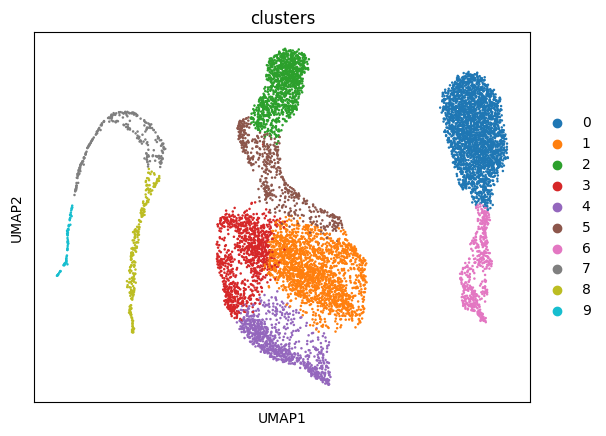

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


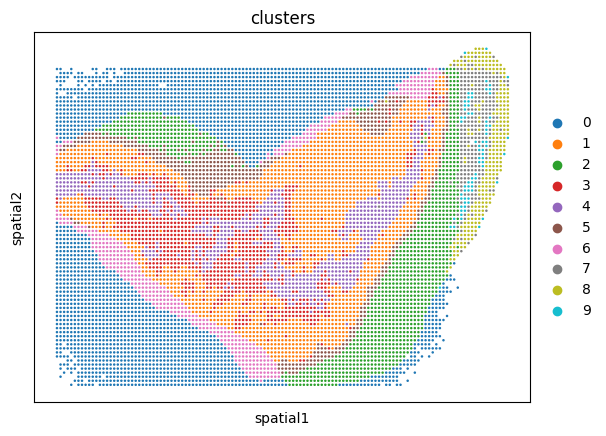

In [395]:
sc.pl.umap(adata, color="clusters")
sc.pl.embedding(adata, basis="spatial", color="clusters")